In [3]:
import os 
import seaborn as sns
import pandas as pd
import numpy as np
#import hdbscan
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity as cos
from scipy.special import logit
from sklearn.cluster import SpectralClustering
from matplotlib.pyplot import figure
import matplotlib.style as style 
import copy
from matplotlib.pyplot import figure
from matplotlib import cm
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage


sns.set()
sns.set_style("white")

%load_ext autoreload
%autoreload 2

sns.set_style(
    'ticks', {
        'axes.grid': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'xtick.bottom': True,
        'ytick.left': True,
        'xtick.color': 'k',
        'ytick.color': 'k'
    })

sns.set_style("white")
style.use('ggplot')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42 #when saving as a pdf, do something with the background

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CHANGE DATA PATH

In [4]:
#DATA_PATH = "/home/pdaly/temp/P_pca_logit-norf_gt-02.csv"
DATA_PATH = "/home/pdaly/temp/boundary_pca_l1_gt-02.csv"
LABELS = "/home/kscangos/Sandbox/full_patient_list_pd_feb.csv"
P = pd.read_csv(DATA_PATH, index_col = 0).T

df = pd.read_csv('/home/pdaly/supereeg/data/apr6_100samp_2h_ml/df.csv', index_col=0)
depr_recs = list(set(df[df.dep ==1].index))

In [5]:
def sig(x):
    return 1/(1+np.exp(-x))

def occlude_feature_sensitivity(feature_list, X):
    """
    Return matrix with columns dropped from feature_list
    parameter: X pandas.DataFrame
    """
    assert type(X) == pd.DataFrame
    X_occ = X.drop(feature_list, axis=1)
    prob_occ = sig(X_occ.agg(sum,axis=1))
    prob_full = sig(X.agg(sum,axis=1))
    return prob_full - prob_occ


def plot_corr(samp, title, inds = np.array([]), size=(12,12), vmin=None, vmax=None):
    corr = samp.corr()
    if len(inds) == 0:
        inds = np.arange(corr.shape[0])
    elif inds == "ascending":
        means = np.mean(corr, axis=1)
        inds = np.argsort(means)
    elif inds == "descending":
        means = np.mean(corr, axis=1)
        inds = np.argsort(means)[::-1]
    corr = corr.values[np.ix_(inds, inds)]
    plt.figure(figsize=size)
    plt.matshow(corr, fignum=1, vmin=vmin, vmax=vmax)
    plt.xticks(range(samp.shape[1]), samp.columns[inds], fontsize=14, rotation=45)
    plt.yticks(range(samp.shape[1]), samp.columns[inds], fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=12)
    plt.grid()
    return plt.title(title, fontsize=16, y=1.15)

In [6]:
def plot_stacked_probabilities(pat_probs,title, xlabel, ylabel, color_order, save_dir = "",top=True, bottom=False, ax=None):
    """
    This method replaces the rather tedious and needlessly wordy cells that plotted 
    the activity bars. 
    This subroutine plots the result of occluding each cluster from the classification for each patient.
    
    Parameters
    ----------
    
        -pat_probs : pd.DataFrame with an index of the patient ids
            and the columns being the cluster activity contribution
            to probability of MDD classification
            
        - title : str of what you want to title the figure
        
        - xlabel : str label for the xaxis
        
        - ylabel : str label for the y axis
        
        - color_order : str codes for color coating each bar. First entry will be topmost bar
        
        - sav_dir : str location you want to save figures to
    """
    pat_neg_probs = pat_probs[pat_probs <0].fillna(0.0)
    pat_pos_probs = pat_probs[pat_probs >= 0].fillna(0.0)
    if ax is None:
        fig, ax = plt.subplots(figsize=[11,8])
    offset = 0
    if top:
        for i in range(len(pat_pos_probs.columns)):

            color = color_order[i]
            cols = list(range(0,len(pat_pos_probs.columns) - offset))
            sns.barplot(x = pat_pos_probs.index.values, y =pat_pos_probs.iloc[:,cols].sum(axis=1),\
                color = color, order = pat_pos_probs.index)
            offset += 1

   #overlaying negative vals
    offset = 0
    if bottom:
        for i in range(len(pat_neg_probs.columns)):
            color = color_order[i]
            cols = list(range(0,len(pat_pos_probs.columns) - offset))
            sns.barplot(x = pat_neg_probs.index.values, y =pat_neg_probs.iloc[:,cols].sum(axis=1),\
                color = color, order = pat_neg_probs.index)
            offset += 1 
    #saving figure

    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.set_ylim((-1,1))
    #if save_dir != "":
    #    plt.savefig(save_dir, transparent=True)



In [7]:
P_sig

NameError: name 'P_sig' is not defined

In [8]:
notkeep = np.abs(P).mean(axis=1) < 0.15
throw_out = notkeep[notkeep].index
P_sig = P.drop(throw_out)
# P_sig = P_sig.drop(['cluster'],axis=1)
P_sig_MDD = P_sig[depr_recs]

cos_sig = 1- cos(P_sig_MDD, P_sig_MDD)

KeyError: '[132 136   9 142 143 150 155 159 166 175 179 186 192  82  84  87  91  96\n 100 107 108 118 125] not in index'

In [9]:
P_sig

,92,111,119,131,135,27,115,130,144,158,162,170,183
alpha_0,-0.051176,0.419771,0.228955,0.112250,0.232445,0.071557,0.473539,0.035205,0.447243,0.096077,0.040831,-0.725057,0.024765
alpha_1,0.072562,-0.426474,-0.368656,-0.084395,-0.337757,0.059259,-0.514645,-0.013749,-0.255267,0.072910,0.103093,0.298334,-0.032728
alpha_2,-0.086846,0.405766,0.253872,0.074328,0.364945,0.161604,0.423108,-0.001445,0.345121,0.105251,0.093433,-0.589783,-0.013356
alpha_4,0.098823,-0.508529,-0.352534,-0.143263,-0.472627,-0.201962,-0.623196,-0.153997,-0.263891,-0.210056,0.004211,0.507140,0.078351
alpha_5,0.029639,-0.338999,-0.311843,-0.105771,-0.315280,-0.010861,-0.424740,-0.104989,-0.263597,-0.088274,0.126039,0.150397,0.021494
beta_0,-0.392592,0.435281,0.073986,-0.019959,0.096889,0.076367,0.408168,-0.156763,0.465350,0.073437,0.057249,-0.289517,0.181459
beta_1,0.432602,-0.535083,-0.154340,0.073394,-0.228500,-0.080572,-0.625838,0.225272,-0.462343,-0.007834,-0.084627,0.062837,-0.203888
delta_0,0.042105,0.597776,0.122255,0.159597,0.146988,-0.037365,0.329230,-0.036683,0.471578,0.030838,-0.128944,-0.470384,0.121540
delta_1,-0.065743,-0.485013,-0.302650,-0.098873,-0.311681,0.056380,-0.415931,0.030236,-0.249396,0.169203,0.181726,0.123322,-0.143483
delta_2,0.016845,0.479566,0.077569,0.153113,0.305136,-0.007646,0.308141,-0.039566,0.306533,0.054276,-0.083347,-0.300167,0.032014


# CHANGE THRESHOLD BELOW

In [10]:
P = pd.read_csv(DATA_PATH, index_col = 0).T
clusters = {0: ["beta_1", "alpha_4", "alpha_1", "alpha_5", "delta_1", "delta_4"],\
            1: ["theta_0","theta_2","theta_4", "beta_0", "delta_0", "delta_2", "alpha_0", "alpha_2"],\
        }
#clusters = {0: ['beta_2', 'alpha_5', 'alpha_2', 'alpha_6', 'delta_2', 'delta_5'],\
#            1: ['theta_1', 'theta_3', 'theta_5', 'beta_1', 'delta_1', 'delta_3', 'alpha_1', 'alpha_3'],\
#        }
cset = set(list(clusters[0])).union(set(list(clusters[1])))
og = set(P.index)
clust_2 = list(og.difference(cset))
clusters[2] = clust_2
cluster_dict = {}
for key in clusters:
    bands = clusters[key]
    for b in bands:
        cluster_dict[b] = key
P['cluster'] = [cluster_dict[ix] for ix in P.index]

In [11]:
# With just values > .15
Pf = pd.DataFrame(index=P.drop(["cluster"], axis=1).columns)
for clust in clusters:
    samp = P[P['cluster'] == clust].drop(["cluster"], axis=1)
    Pf['clust_{}_diff'.format(clust)] = occlude_feature_sensitivity(samp.T.columns, P.T.drop("cluster")) 
Pf.head()

,clust_0_diff,clust_1_diff,clust_2_diff
92,0.082858,0.132661,0.057365
111,-0.328133,0.536334,0.145555
119,-0.387034,0.150355,-0.126362
131,-0.125485,0.262475,-0.318489
135,-0.432532,0.236954,0.092420


In [12]:
P_sig_MDD["cluster"] =  [cluster_dict[val] for val in P_sig_MDD.index]
P_sig_MDD.head()

NameError: name 'P_sig_MDD' is not defined

In [13]:
# # shift_thresh = 0
# # diff_df = pd.DataFrame(columns=["cluster", "diff","pat_index"])
clust_dict = {}

shift_thresh = 0
P = P_sig_MDD
diff_df = pd.DataFrame(columns=["cluster", "diff","pat_index"])

NameError: name 'P_sig_MDD' is not defined

In [14]:
P_sig_MDDr = P_sig_MDD.drop(['cluster'], axis=1)
clust_map = sns.clustermap(P_sig_MDDr, vmin=.1, vmax=.7, metric="cosine",cmap="nipy_spectral")
#clust_map.savefig("/home/kscangos/paper_figs/hierarchical_graph-gt.pdf", transparent=True)

NameError: name 'P_sig_MDD' is not defined

In [15]:
P_sig_MDDr = P_sig_MDD.drop(['cluster'], axis=1)
clust_map = sns.clustermap(P_sig_MDDr, vmin=.1, vmax=.7, metric="cosine",cmap="nipy_spectral")
#clust_map.savefig("/home/kscangos/paper_figs/hierarchical_graph-gt_015.pdf", transparent=True)

NameError: name 'P_sig_MDD' is not defined

In [16]:
bt1_pids = [87, 125, 142, 84, 82, 166, 118, 96]
bt2_pids = [91, 192, 107, 108, 9, 175, 143]

In [17]:
P_sig_MDDr.T.shape

NameError: name 'P_sig_MDDr' is not defined

In [18]:
#nep1_cols = ['beta_2', 'alpha_5', 'alpha_2', 'alpha_6', 'delta_2', 'delta_5']
#nep2_colcs = ['theta_1', 'theta_3', 'theta_5', 'beta_1', 'delta_1', 'delta_3', 'alpha_1', 'alpha_3']

In [19]:
nep1_cols = ['beta_1', 'alpha_4', 'alpha_1', 'alpha_5', 'delta_1', 'delta_4']
nep2_colcs = ['theta_0', 'theta_2', 'theta_4', 'beta_0', 'delta_0', 'delta_2', 'alpha_0', 'alpha_2']

In [20]:
Pf = Pf.sort_values(['clust_0_diff'])
Pf_MDD = Pf[Pf.index.isin(depr_recs)]
PF_norm = Pf[~Pf.index.isin(depr_recs)]

In [21]:
PF_norm

,clust_0_diff,clust_1_diff,clust_2_diff
115,-0.631963,0.136909,0.034429
135,-0.432532,0.236954,0.092420
119,-0.387034,0.150355,-0.126362
111,-0.328133,0.536334,0.145555
144,-0.300826,0.388565,0.095951
131,-0.125485,0.262475,-0.318489
183,-0.060682,0.030059,0.081050
158,-0.042662,0.029203,0.006352
27,-0.040701,-0.141216,0.002235
130,-0.016757,0.051646,-0.017312


ValueError: min() arg is an empty sequence

<Figure size 432x288 with 0 Axes>

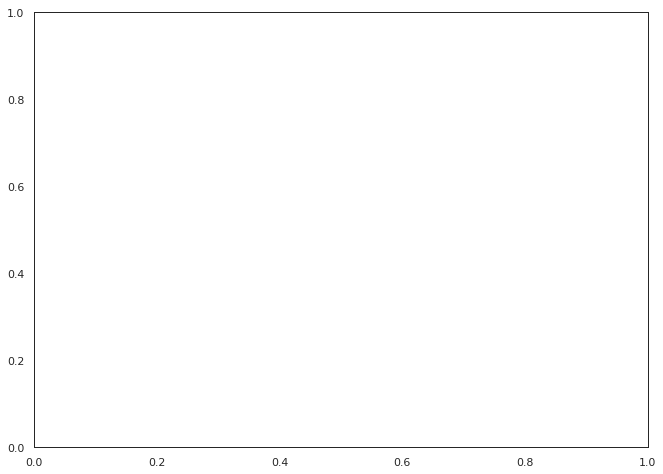

In [22]:
title = "Stacked Probabilities for MDD group with Most Important Features MISCLASS: 100, 150, 179"
xlabel = "MDD Patient"
ylabel = 'Stacked Risks from different Activity Areas'
color = ["#32CD32","#3498db","#9b59b6","#e74c3c"]  #"#34495e","#95a5a6" 
sns.set_style("white")
sns.despine()
plt.tight_layout()
plot_stacked_probabilities(Pf_MDD,title, xlabel, ylabel,color, bottom=True)#, save_dir='/home/kscangos/Sandbox/stacked_probs_MDD_sig.pdf')

<Figure size 432x288 with 0 Axes>

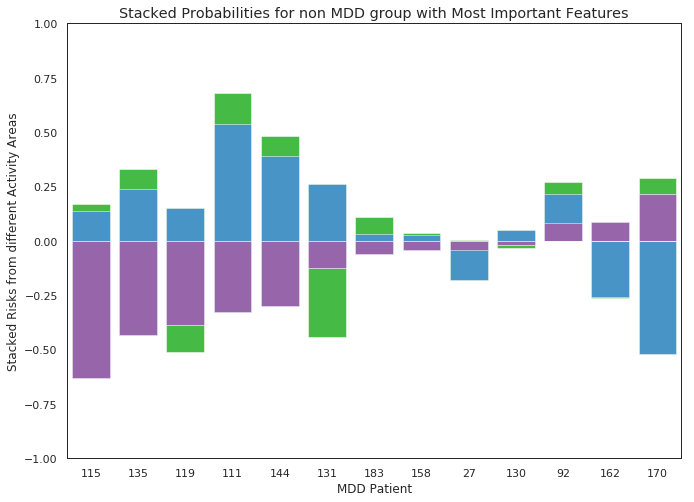

In [23]:
title = "Stacked Probabilities for non MDD group with Most Important Features"
xlabel = "MDD Patient"
ylabel = 'Stacked Risks from different Activity Areas'
color = ["#32CD32","#3498db","#9b59b6","#e74c3c"]  #"#34495e","#95a5a6" 
sns.set_style("white")
sns.despine()
plt.tight_layout()
plot_stacked_probabilities(PF_norm,title, xlabel, ylabel,color, bottom =True)#, save_dir='/home/kscangos/Sandbox/stacked_probs_noMDD_sig.pdf')

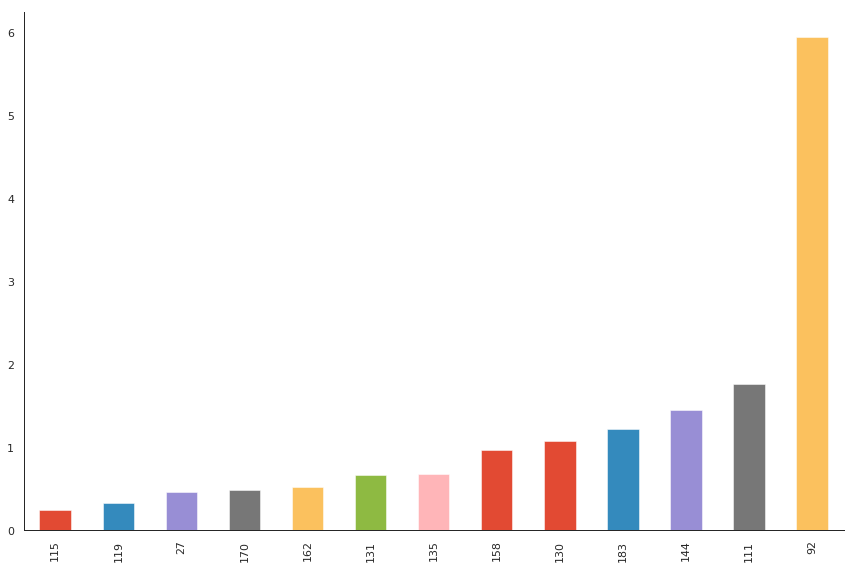

In [24]:
# odds ratio
fig, ax = plt.subplots(figsize=(12, 8))
P.drop('cluster', axis=1).T.sum(axis=1).apply(np.exp).sort_values().plot(kind='bar')
sns.despine();
plt.tight_layout()
#plt.savefig("/home/kscangos/Sandbox/oddsratio.pdf", transparent=True)

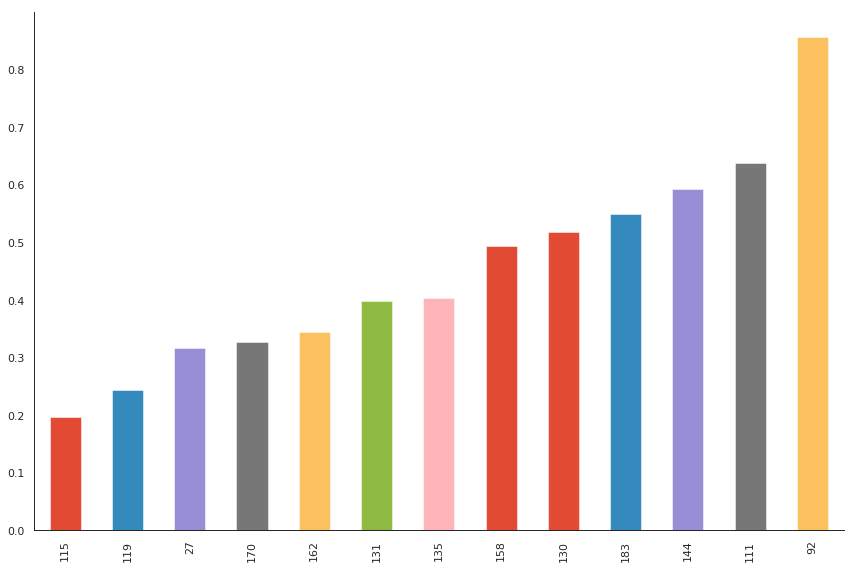

In [25]:
# probability
fig, ax = plt.subplots(figsize=(12, 8))
P.drop('cluster', axis=1).T.sum(axis=1).apply(lambda x: 1 / (1 + np.exp(-x))).sort_values().plot(kind='bar')
sns.despine();
plt.tight_layout()
#plt.savefig("/home/kscangos/Sandbox/prob.pdf", transparent=True)

In [26]:
P.drop('cluster', axis=1).T.sum(axis=1).apply(lambda x: 1 / (1 + np.exp(-x))).sort_values()

115    0.197028
119    0.244230
27     0.315845
170    0.326170
162    0.343985
131    0.398464
135    0.403001
158    0.492899
130    0.517533
183    0.548966
144    0.592430
111    0.637771
92     0.855867
dtype: float64

TypeError: Empty 'DataFrame': no numeric data to plot

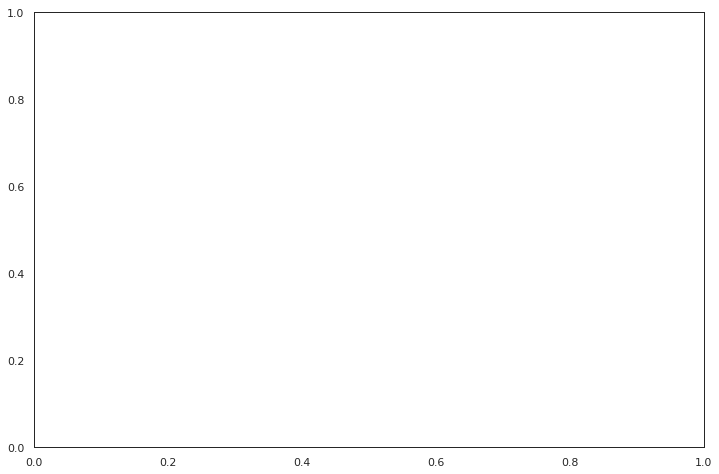

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
Pfg = Pf.join(df.dep)
Pfg.groupby('dep').mean().plot(kind='bar', ax=ax);
sns.despine();

KeyError: 'None of [[87, 125, 142, 82, 166, 118, 96]] are in the [index]'

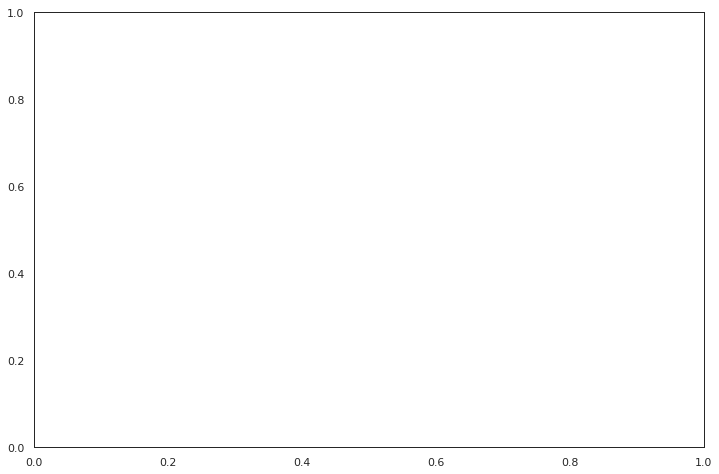

In [28]:
#btypes = {
#    0: [186, 96, 118, 82, 142, 166, 87, 125, 179, 84],
#    1: [132, 159, 192, 91, 107, 136, 150, 100, 9, 155, 143, 175, 108]
#}
btypes = {
    0: [87, 125, 142, 82, 166, 118, 96],
    1: [136, 159, 91, 192, 155, 9, 107, 108, 175, 143]
}

fig, ax = plt.subplots(figsize=(12, 8))
btype0 = Pfg.loc[btypes[0]].clust_0_diff.mean()
btype0_std = Pfg.loc[btypes[0]].clust_0_diff.std()
btype1 = Pfg.loc[btypes[1]].clust_1_diff.mean()
btype1_std = Pfg.loc[btypes[1]].clust_1_diff.std()

plt.bar(['btype_0', 'btype_1'], [btype0, btype1], 
        yerr=[btype0_std, btype1_std], color=["#9b59b6", "#34495e"])

sns.despine();
plt.tight_layout();

#plt.savefig("/home/kscangos/Sandbox/btype_nep_contribution.pdf", transparent=True)

In [29]:
plt.bar(['btype_0', 'btype_1'], [btype0*1.2, btype1*1.2], 
        yerr=[btype0_std, btype1_std], color=["#9b59b6", "#34495e"], alpha=0.75)
plt.bar(['btype_0', 'btype_1'], [btype0, btype1], 
        yerr=[btype0_std, btype1_std], color=["#e74c3c","#3498db"], alpha=0.25)

NameError: name 'btype0' is not defined

ValueError: min() arg is an empty sequence

<Figure size 432x288 with 0 Axes>

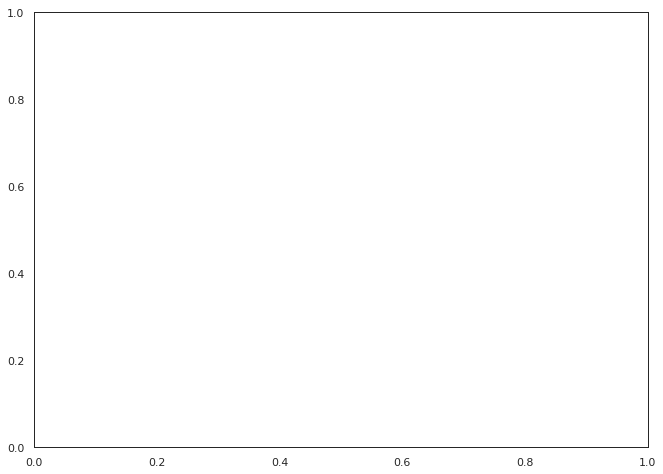

In [30]:
title = "Stacked Probabilities for MDD group with Most Important Features MISCLASS: 100, 150, 179"
xlabel = "MDD Patient"
ylabel = 'Stacked Risks from different Activity Areas'
color = ["#32CD32","#3498db","#9b59b6","#e74c3c"]  #"#34495e","#95a5a6" 
sns.set_style("white")
sns.despine()
plt.tight_layout()
plot_stacked_probabilities(Pf_MDD, title, xlabel, ylabel,color, bottom=True)

In [31]:
# probas = pd.read_csv('~/temp/preds_pca-logit.csv', index_col=0)
probas = pd.read_csv('/home/pdaly/temp/boundary_pca_l1_gt-02_probas.csv', index_col=0)

In [32]:
probas

,proba,actual,pred,match
92,0.855867,0,1,False
111,0.637771,0,1,False
119,0.244230,0,0,True
131,0.398464,0,0,True
135,0.403001,0,0,True
27,0.315845,0,0,True
115,0.197028,0,0,True
130,0.517533,0,1,False
144,0.592430,0,1,False
158,0.492899,0,0,True


In [33]:
# missclassified
probas[(probas.match == False) & (probas.actual == 1)]

,proba,actual,pred,match


In [34]:
Pf_MDD['btype'] = Pf_MDD['clust_0_diff'].apply(lambda d:
                'bt_1' if d >= 0 else 'bt_2')
temp = pd.concat([
    Pf_MDD[Pf_MDD['btype'] == 'bt_1'].sort_values('clust_0_diff', ascending=False),
    Pf_MDD[Pf_MDD['btype'] == 'bt_2'].sort_values('clust_1_diff', ascending=True)]
).drop('btype', axis=1)

#title = "Stacked Probabilities for MDD group with Most Important Features MISCLASS: 100, 150, 179"
title = "Stacked Probabilities for MDD group with Most Important Features MISCLASS: 84, 100, 150, 179"
xlabel = "MDD Patient"
ylabel = 'Stacked Risks from different Activity Areas'

color = ["#32CD32","#3498db","#9b59b6","#e74c3c"]  #"#34495e","#95a5a6" 
sns.set_style("white")
sns.despine()

fig, ax = plt.subplots(figsize=(12, 8))

ps = probas.loc[temp.index, 'proba']
#sns.barplot(x=ps.index, y=ps.values, color="#3498db", alpha=0.5, ax=ax)
ps.plot(kind='bar', width=0.8, color="#3498db", alpha=0.5, ax=ax)
plot_stacked_probabilities(temp, title, xlabel, ylabel,color, bottom=True, ax=ax)

plt.tight_layout()
sns.despine();

#plt.savefig("../temp/nep_and_probas_barchart-mdd_aug20.pdf", transparent=True)

/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/pandas/core/ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

In [35]:
#bt1_pids = [87, 125, 142, 84, 82, 166, 118, 96]
#bt2_pids = [91, 192, 107, 108, 9, 175, 143]
bt1_pids = [87, 125, 142, 82, 166, 118, 96]
bt2_pids = [136, 159, 91, 192, 155, 9, 107, 108, 175, 143]

In [36]:
bts = pd.DataFrame(pd.concat([temp.loc[bt1_pids, 'clust_0_diff'], 
                 temp.loc[bt2_pids, 'clust_1_diff']]), columns=['diff'])
bts['btype'] = ['bt1'] * 7 + ['bt2'] * 10
means = bts.groupby('btype').mean().values.T.tolist()[0]
stds = bts.groupby('btype').std().values.T.tolist()[0]
plt.bar(['btype_0', 'btype_1'], means, yerr=stds, color=["#9b59b6", "#34495e"])

sns.despine();
plt.tight_layout()

#plt.savefig('/home/pdaly/temp/btype_bar.pdf', transparent=True)

NameError: name 'temp' is not defined

In [37]:
means

NameError: name 'means' is not defined

In [38]:
pd.DataFrame([means, stds], index=['means', 'stds'], columns=['bt1', 'bt2'])

NameError: name 'means' is not defined

In [39]:
PF_norm['btype'] = PF_norm['clust_0_diff'].apply(lambda d:
                'bt_1' if d >= 0 else 'bt_2')

In [50]:
# missclassified
probas[(probas.match == False) & (probas.actual == 0)]

,proba,actual,pred,match
92,0.855867,0,1,False
111,0.637771,0,1,False
130,0.517533,0,1,False
144,0.592430,0,1,False
183,0.548966,0,1,False


<Figure size 432x288 with 0 Axes>

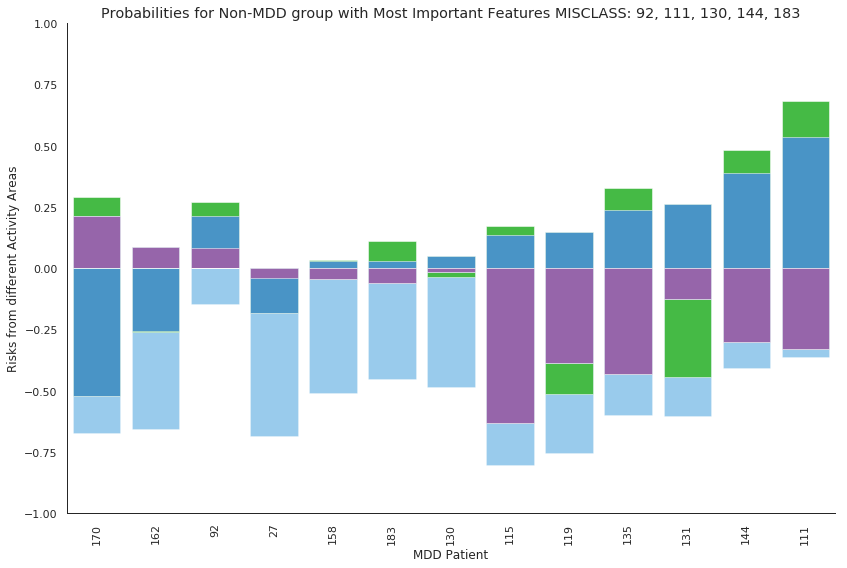

In [41]:
PF_norm['btype'] = PF_norm['clust_0_diff'].apply(lambda d:
                'bt_1' if d >= 0 else 'bt_2')
temp = pd.concat([
    PF_norm[PF_norm['btype'] == 'bt_1'].sort_values('clust_0_diff', ascending=False),
    PF_norm[PF_norm['btype'] == 'bt_2'].sort_values('clust_1_diff', ascending=True)]
).drop('btype', axis=1)

title = "Probabilities for Non-MDD group with Most Important Features MISCLASS: 92, 111, 130, 144, 183"
xlabel = "MDD Patient"
ylabel = 'Risks from different Activity Areas'

color = ["#32CD32","#3498db","#9b59b6","#e74c3c"]  #"#34495e","#95a5a6" 
sns.set_style("white")
sns.despine()

fig, ax = plt.subplots(figsize=(12, 8))

ps = -(1-(probas.loc[temp.index, 'proba']))
#sns.barplot(x=ps.index, y=ps.values, color="#3498db", alpha=0.5, ax=ax)
ps.plot(kind='bar', width=0.8, color="#3498db", alpha=0.5, ax=ax)
plot_stacked_probabilities(temp, title, xlabel, ylabel,color, bottom=True, ax=ax)

plt.tight_layout()
sns.despine();

#plt.savefig("../temp/nep_and_probas_barchart-no_mdd_oct14-boundary.pdf", transparent=True)

In [134]:
g1 = [170, 162]
g2 = [115, 119, 135, 131]
mix = [158, 27]
missed = [92, 111, 130, 144, 183]

In [135]:
-(1-(probas.loc[temp.index, 'proba'])).mean()

-0.5481392165452714

In [136]:
temp.drop('group', axis=1, inplace=True)

In [137]:
#temp = temp.rename(columns={'clust_0_diff': 'purple', 'clust_1_diff': 'dark_blue', 'clust_2_diff': 'green'})
temp.loc[g1, 'group'] = 'Group-1'
temp.loc[g2, 'group'] = 'Group-2'
temp.loc[missed, 'group'] = 'Missclassified'

In [138]:
nf = temp.rename(columns={'purple': 'nep_1', 'dark_blue': 'nep_2'}).drop('green', axis=1)

In [139]:
nf.reset_index()

,index,nep_1,nep_2,group
0,170,0.215181,-0.521768,Group-1
1,162,0.088958,-0.256728,Group-1
2,92,0.082858,0.132661,Missclassified
3,27,-0.040701,-0.141216,NaN
4,158,-0.042662,0.029203,NaN
5,183,-0.060682,0.030059,Missclassified
6,130,-0.016757,0.051646,Missclassified
7,115,-0.631963,0.136909,Group-2
8,119,-0.387034,0.150355,Group-2
9,135,-0.432532,0.236954,Group-2


In [140]:
nf[nf.group == 'Group-1']

,nep_1,nep_2,group
170,0.215181,-0.521768,Group-1
162,0.088958,-0.256728,Group-1


In [141]:
nf[nf.group.notnull()].reset_index().set_index(['index', 'group']).stack().to_frame().reset_index()\
            .rename(columns={'level_2': 'nep', 0: 'Probability'}).groupby(['group', 'nep']).agg(['mean', 'std'])

index            Probability          
                      mean        std        mean       std
group          nep                                         
Group-1        nep_1   166   5.656854    0.152069  0.089253
               nep_2   166   5.656854   -0.389248  0.187412
Group-2        nep_1   125   9.521905   -0.394254  0.208374
               nep_2   125   9.521905    0.196673  0.062368
Missclassified nep_1   132  34.604913   -0.124708  0.181132
               nep_2   132  34.604913    0.227853  0.223731

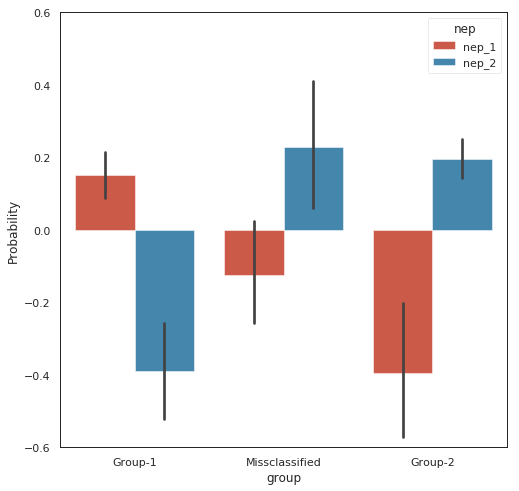

In [101]:
plt.subplots(figsize=(8, 8))
sns.barplot(x='group', y='Probability', hue='nep',
            data=nf[nf.group.notnull()].reset_index().set_index(['index', 'group']).stack().to_frame().reset_index()\
            .rename(columns={'level_2': 'nep', 0: 'Probability'}))

plt.ylim([-0.6, 0.6])

plt.savefig("../temp/nep_barchart_both_groups-boundary_with_missclassified.pdf", transparent=True)

In [48]:
prl5 = probas.loc[temp.index.values]
prl5

,proba,actual,pred,match
170,0.326170,0,0,True
162,0.343985,0,0,True
92,0.855867,0,1,False
27,0.315845,0,0,True
158,0.492899,0,0,True
183,0.548966,0,1,False
130,0.517533,0,1,False
115,0.197028,0,0,True
119,0.244230,0,0,True
135,0.403001,0,0,True


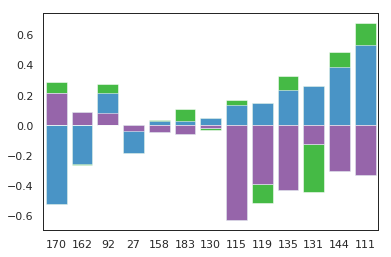

In [47]:
plot_stacked_probabilities(temp, title, xlabel, ylabel,color, bottom=True, ax=ax)

In [173]:
#               green   darker blue  purple   red
color_order = ["#32CD32","#3498db","#9b59b6","#e74c3c"]

(-1, 1)

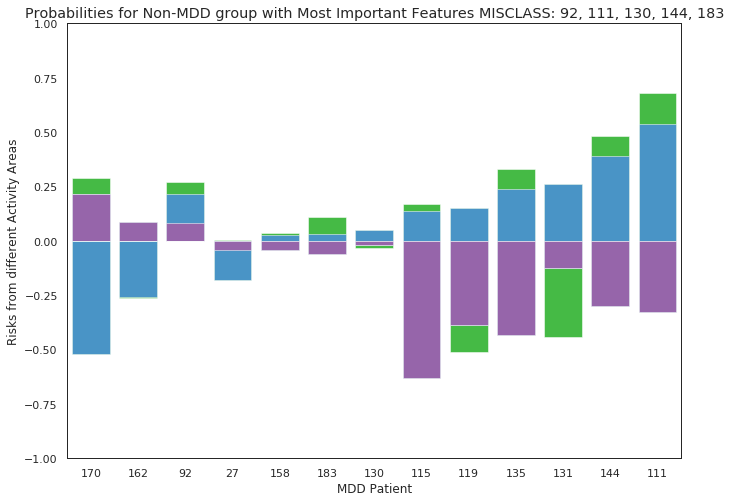

In [89]:
pat_neg_probs = temp[temp <0].fillna(0.0)
pat_pos_probs = temp[temp >= 0].fillna(0.0)

fig, ax = plt.subplots(figsize=[11,8])

offset = 0

for i in range(len(pat_pos_probs.columns)):
    color = color_order[i]
    cols = list(range(0,len(pat_pos_probs.columns) - offset))
    sns.barplot(x = pat_pos_probs.index.values, y =pat_pos_probs.iloc[:,cols].sum(axis=1),\
        color = color, order = pat_pos_probs.index)
    offset += 1

#overlaying negative vals
offset = 0
for i in range(len(pat_neg_probs.columns)):
    color = color_order[i]
    cols = list(range(0,len(pat_pos_probs.columns) - offset))
    sns.barplot(x = pat_neg_probs.index.values, y =pat_neg_probs.iloc[:,cols].sum(axis=1),\
        color = color, order = pat_neg_probs.index)
    offset += 1 
#saving figure

ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
ax.set_ylim((-1,1))
#if save_dir != "":
#    plt.savefig(save_dir, transparent=True)

In [ ]:
probas

In [ ]:
temp

In [98]:
# plot average 
g1 = [170, 162, 27]
g2 = [115, 119, 135, 131]
mix = [158]

In [104]:
from IPython.display import display

In [ ]:
# green   darker blue  purple

In [114]:
tbl = {'clust_0_diff': 'green', 'clust_1_diff': 'dark_blue', 'clust_2_diff': 'purple'}

,green,dark_blue,purple
170,0.215181,-0.521768,0.074355
162,0.088958,-0.256728,-0.004064
27,-0.040701,-0.141216,0.002235


green        0.087813
dark_blue   -0.306571
purple       0.024176
dtype: float64

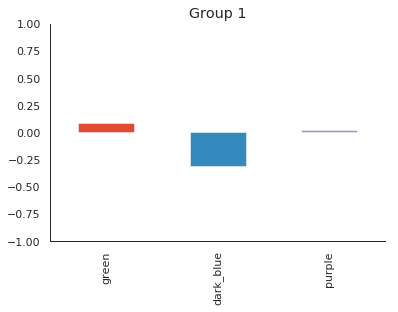

In [174]:
display(temp.loc[g1].rename(columns=tbl))
display(temp.loc[g1].rename(columns=tbl).mean())
display(temp.loc[g1].rename(columns=tbl).mean().plot(kind='bar'))

plt.ylim([-1, 1])
plt.title('Group 1')

sns.despine()

plt.savefig("../temp/nep_barchart_group1-boundary.pdf", transparent=True)

,green,dark_blue,purple
115,-0.631963,0.136909,0.034429
119,-0.387034,0.150355,-0.126362
135,-0.432532,0.236954,0.092420
131,-0.125485,0.262475,-0.318489


green       -0.394254
dark_blue    0.196673
purple      -0.079501
dtype: float64

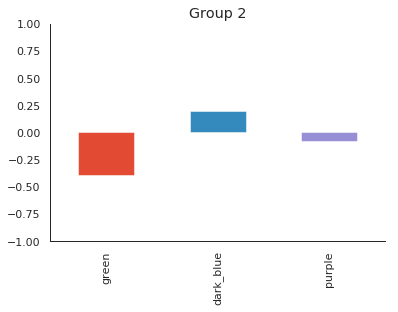

In [175]:
display(temp.loc[g2].rename(columns=tbl))
display(temp.loc[g2].rename(columns=tbl).mean())
display(temp.loc[g2].rename(columns=tbl).mean().plot(kind='bar'))

plt.ylim([-1, 1])
plt.title('Group 2')

sns.despine()

plt.savefig("../temp/nep_barchart_group2-boundary.pdf", transparent=True)

In [117]:
temp.rename(columns=tbl).loc[mix]

,green,dark_blue,purple
158,-0.042662,0.029203,0.006352


In [118]:
bts = pd.read_csv('/home/pdaly/temp/mdd_biotypes_nep_contributions.csv')

In [127]:
temp.loc[g1].describe().loc[['count', 'mean', 'std']]

,purple,dark_blue,green
count,2.000000,2.000000,2.000000
mean,0.152069,-0.389248,0.035146
std,0.089253,0.187412,0.055451


In [128]:
temp.loc[g2].describe().loc[['count', 'mean', 'std']]

,purple,dark_blue,green
count,4.000000,4.000000,4.000000
mean,-0.394254,0.196673,-0.079501
std,0.208374,0.062368,0.184253


In [132]:
bts[bts.btype == 'bt1'].describe().loc[['count', 'mean', 'std']].drop('index', axis=1)

,diff
count,7.000000
mean,0.377927
std,0.130282


In [133]:
bts[bts.btype == 'bt2'].describe().loc[['count', 'mean', 'std']].drop('index', axis=1)

,diff
count,10.000000
mean,0.386430
std,0.178954


In [111]:
from scipy.stats import ttest_ind

In [123]:
ttest_ind(temp.loc[g1].purple, bts[bts.btype == 'bt1']['diff'])

Ttest_indResult(statistic=-2.2491212940979515, pvalue=0.05927489819739492)

In [124]:
ttest_ind(temp.loc[g2].dark_blue, bts[bts.btype == 'bt2']['diff'])

Ttest_indResult(statistic=-2.0289467538644623, pvalue=0.06524934598427504)